# Data Loading

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import os
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


In [33]:
# sindhu
path = r'drive/My Drive/FAI/Code/dataset'

In [34]:
file_list = os.listdir(path)
print(file_list)

['Telco_customer_churn_population.xlsx', 'Telco_customer_churn_services.xlsx', 'Telco_customer_churn_status.xlsx', 'Telco_customer_churn_demographics.xlsx', 'Telco_customer_churn_location.xlsx', 'Telco_customer_churn.xlsx']


In [40]:
import pandas as pd

demographics_df = pd.read_excel(path + '/Telco_customer_churn_demographics.xlsx')
location_df = pd.read_excel(path + '/Telco_customer_churn_location.xlsx')
population_df = pd.read_excel(path + '/Telco_customer_churn_population.xlsx')
services_df = pd.read_excel(path + '/Telco_customer_churn_services.xlsx')
status_df = pd.read_excel(path + '/Telco_customer_churn_status.xlsx')


In [41]:
print(demographics_df.head())
print("------------------------------------------------------------------------")
print(location_df.head())
print("------------------------------------------------------------------------")
print(population_df.head())
print("------------------------------------------------------------------------")
print(services_df.head())
print("------------------------------------------------------------------------")
print(status_df.head())

  Customer ID  Count  Gender  Age Under 30 Senior Citizen Married Dependents  \
0  8779-QRDMV      1    Male   78       No            Yes      No         No   
1  7495-OOKFY      1  Female   74       No            Yes     Yes        Yes   
2  1658-BYGOY      1    Male   71       No            Yes      No        Yes   
3  4598-XLKNJ      1  Female   78       No            Yes     Yes        Yes   
4  4846-WHAFZ      1  Female   80       No            Yes     Yes        Yes   

   Number of Dependents  
0                     0  
1                     1  
2                     3  
3                     1  
4                     1  
------------------------------------------------------------------------
  Customer ID  Count        Country       State         City  Zip Code  \
0  8779-QRDMV      1  United States  California  Los Angeles     90022   
1  7495-OOKFY      1  United States  California  Los Angeles     90063   
2  1658-BYGOY      1  United States  California  Los Angeles     900

In [42]:
# Merge on CustomerID
df = pd.merge(demographics_df, location_df, on='Customer ID')
df = pd.merge(df, services_df, on='Customer ID')
# Rename the 'Count' column in status_df before merging to avoid conflict
status_df = status_df.rename(columns={'Count': 'Status_Count_x'})
df = pd.merge(df, status_df, on='Customer ID')


# Merge Population data
df = pd.merge(df, population_df, on='Zip Code')
print(df.head())

  Customer ID  Count_x  Gender  Age Under 30 Senior Citizen Married  \
0  8779-QRDMV        1    Male   78       No            Yes      No   
1  7495-OOKFY        1  Female   74       No            Yes     Yes   
2  1658-BYGOY        1    Male   71       No            Yes      No   
3  4598-XLKNJ        1  Female   78       No            Yes     Yes   
4  4846-WHAFZ        1  Female   80       No            Yes     Yes   

  Dependents  Number of Dependents  Count_y  ... Satisfaction Score  \
0         No                     0        1  ...                  3   
1        Yes                     1        1  ...                  3   
2        Yes                     3        1  ...                  2   
3        Yes                     1        1  ...                  2   
4        Yes                     1        1  ...                  2   

  Customer Status Churn Label  Churn Value Churn Score  CLTV   Churn Category  \
0         Churned         Yes            1          91  5433     

In [43]:
df.columns

Index(['Customer ID', 'Count_x', 'Gender', 'Age', 'Under 30', 'Senior Citizen',
       'Married', 'Dependents', 'Number of Dependents', 'Count_y', 'Country',
       'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude',
       'Count', 'Quarter_x', 'Referred a Friend', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Status_Count_x', 'Quarter_y', 'Satisfaction Score',
       'Customer Status', 'Churn Label', 'Churn Value', 'Churn Score', 'CLTV'

In [44]:
# Identify and remove duplicate columns which got inserted during the merge operation
duplicate_columns = []
for col in df.columns:
    if col.endswith('_x') or col.endswith('_y'):
        duplicate_columns.append(col)

print("Duplicate columns:", duplicate_columns)

df.drop(columns=duplicate_columns, inplace=True)

Duplicate columns: ['Count_x', 'Count_y', 'Quarter_x', 'Status_Count_x', 'Quarter_y']


In [45]:
print(df.head())

  Customer ID  Gender  Age Under 30 Senior Citizen Married Dependents  \
0  8779-QRDMV    Male   78       No            Yes      No         No   
1  7495-OOKFY  Female   74       No            Yes     Yes        Yes   
2  1658-BYGOY    Male   71       No            Yes      No        Yes   
3  4598-XLKNJ  Female   78       No            Yes     Yes        Yes   
4  4846-WHAFZ  Female   80       No            Yes     Yes        Yes   

   Number of Dependents        Country       State  ... Satisfaction Score  \
0                     0  United States  California  ...                  3   
1                     1  United States  California  ...                  3   
2                     3  United States  California  ...                  2   
3                     1  United States  California  ...                  2   
4                     1  United States  California  ...                  2   

   Customer Status Churn Label  Churn Value  Churn Score  CLTV  \
0          Churned        

# Data Cleaning
The below steps are followed:
1. Check and fill in for the missing values
2. Check and remove duplicate rows

In [46]:
# 1. Checking for any missing values
print(df.isnull().sum())

Customer ID                             0
Gender                                  0
Age                                     0
Under 30                                0
Senior Citizen                          0
Married                                 0
Dependents                              0
Number of Dependents                    0
Country                                 0
State                                   0
City                                    0
Zip Code                                0
Lat Long                                0
Latitude                                0
Longitude                               0
Count                                   0
Referred a Friend                       0
Number of Referrals                     0
Tenure in Months                        0
Offer                                3877
Phone Service                           0
Avg Monthly Long Distance Charges       0
Multiple Lines                          0
Internet Service                  

In [47]:
# We can see that Churn Reason and Churn Category has a lot of missing values.
# This is expected because for customers who have not churned, there isn't any reason.
# So we will fill in the missing values with either NA or Not churned based on their churn status


df.loc[(df['Churn Reason'].isnull()) & (df['Churn Value'] == 1), 'Churn Reason'] = 'NA'
df.loc[(df['Churn Reason'].isnull()) & (df['Churn Value'] == 0), 'Churn Reason'] = 'Not Churned'

df.loc[(df['Churn Category'].isnull()) & (df['Churn Value'] == 1), 'Churn Category'] = 'NA'
df.loc[(df['Churn Category'].isnull()) & (df['Churn Value'] == 0), 'Churn Category'] = 'Not Churned'

# Checking for missing values to verify
print(df.isnull().sum())

Customer ID                             0
Gender                                  0
Age                                     0
Under 30                                0
Senior Citizen                          0
Married                                 0
Dependents                              0
Number of Dependents                    0
Country                                 0
State                                   0
City                                    0
Zip Code                                0
Lat Long                                0
Latitude                                0
Longitude                               0
Count                                   0
Referred a Friend                       0
Number of Referrals                     0
Tenure in Months                        0
Offer                                3877
Phone Service                           0
Avg Monthly Long Distance Charges       0
Multiple Lines                          0
Internet Service                  

In [48]:
# 2. Checking for any duplicate rows
df = df.drop_duplicates()

# Feature Engineering

In this step, we will analyse and choose the most relevant features to train our model. We create a summary of each feature to understand which of the features are more important to predict the churn outcome.


In [49]:
# 1. Create feature summary
feature_summary = []

for feature in df.columns:
    unique_values = np.unique(df[feature].astype(str))
    feature_summary.append({
        "column_name": feature,
        'unique_value_count': len(unique_values),
        'total_count': len(df),
        'unique_values': unique_values,
        'Datatype': df[feature].dtype
    })

print(pd.DataFrame(feature_summary))

                          column_name  unique_value_count  total_count  \
0                         Customer ID                7043         7043   
1                              Gender                   2         7043   
2                                 Age                  62         7043   
3                            Under 30                   2         7043   
4                      Senior Citizen                   2         7043   
5                             Married                   2         7043   
6                          Dependents                   2         7043   
7                Number of Dependents                  10         7043   
8                             Country                   1         7043   
9                               State                   1         7043   
10                               City                1106         7043   
11                           Zip Code                1626         7043   
12                           Lat Long 

**Findings:**
1. We can see that features like `CustomerID`, `Country`, `State` are redundant features. They are either unique for each observation or same for all of the observations. There is also `Lat Long` which seems to be a combination of `Latitude` and `Longitude`. They do not contribute much to our prediction.
  - TODO: We can remove them to simplify our model.
2. We have few binary features like `Gender`, `Under 30`, `Senior Citizen`, `Married`, `Dependents`, `Referred a Friend`, `Phone Service`, `Multiple Lines`, `Internet Service`, `Online Security`, `Online Backup`, `Device Protection Plan`, `Premium Tech Support`, `Streaming TV`, `Streaming Movies`, `Streaming Music`, `Unlimited Data`, and `Paperless Billing`.
  - TODO: We can use label encoding for use in modelling where the algorithms need numerical inputs.
3. We also have features with multiple categories like `Internet Type`, `Contract`, `Payment Method`, `Customer Status`
  - TODO: We can use one-hot encoding for use in modelling where the algorithms need numerical inputs.
4. There are also continuous numerical features like `Age`, `Number of Dependents`, `Number of Referrals`, `Tenure in Months`, `Avg Monthly Long Distance Charges`, `Avg Monthly GB Download`, `Monthly Charge`, `Total Charges`, `Total Refunds`, `Total Extra Data Charges`, `Total Long Distance Charges`, `Total Revenue`, `Satisfaction Score`, `CLTV`, `Population`
  - TODO: These features might need scaling. Certain algorithms like Logistic Regression, SVMs, Neural Networks assume the features are on the same level.
  - TODO: The field type of `Total Charges` is an object type but should be numerical. We can perform data cleaning step to convert this to float.
5. There are also high cardinality categorical features like `City`, `Zip Code`.
  - TODO: These may require special handling like target encoding or clustering.
6. As per the official documentation on the IBM website, the features `Churn Label`, `Churn Value`, `Churn Score`, `Customer Status`, `Churn Category` and `Churn Reason` are all directly associated with the outcome of customer churn.
  - TODO: We will use `Churn Value` as our target variable. We will remove the remaining features to prevent data leakage.

In [50]:
# Removing irrelevant features
columns_to_remove = ['Customer ID', 'Country', 'State', 'Lat Long']
df = df.drop(columns=columns_to_remove)

# Removing features directly associated with the target variable to prevent Data Leakage
columns_to_remove = ['Churn Category', 'Churn Reason', 'Customer Status', 'Churn Score', 'Churn Label']
df = df.drop(columns=columns_to_remove)

print(df.head())

   Gender  Age Under 30 Senior Citizen Married Dependents  \
0    Male   78       No            Yes      No         No   
1  Female   74       No            Yes     Yes        Yes   
2    Male   71       No            Yes      No        Yes   
3  Female   78       No            Yes     Yes        Yes   
4  Female   80       No            Yes     Yes        Yes   

   Number of Dependents         City  Zip Code   Latitude  ...  Total Charges  \
0                     0  Los Angeles     90022  34.023810  ...          39.65   
1                     1  Los Angeles     90063  34.044271  ...         633.30   
2                     3  Los Angeles     90065  34.108833  ...        1752.55   
3                     1    Inglewood     90303  33.936291  ...        2514.50   
4                     1     Whittier     90602  33.972119  ...        2868.15   

   Total Refunds Total Extra Data Charges  Total Long Distance Charges  \
0           0.00                       20                         0.00  

In [51]:
# Data Type Conversion for 'TotalCharges'
def change_dtype(x):
    try:
        return float(x)
    except ValueError:
        return 0

df['Total Charges'] = df['Total Charges'].apply(lambda x: change_dtype(x))
print(df['Total Charges'].dtype)

float64


In [52]:
# Handling the high-cardinality categorical feature 'City'

# Frequency encoding
city_freq = df['City'].value_counts()
df['City'] = df['City'].map(city_freq)

In [53]:
# Handling the high-cardinality categorical feature 'Zip Code'


# Frequency encoding
zip_freq = df['Zip Code'].value_counts()
df['Zip Code'] = df['Zip Code'].map(zip_freq)

# Target encoding
# mean_churn_per_zip = df.groupby('Zip Code')['Churn Value'].mean()
# df['Zip_Code_Target_Enc'] = df['Zip Code'].map(mean_churn_per_zip)

# df.drop('Zip Code', axis=1, inplace=True)

In [54]:
# Handling Categorical Features

# Label Encoding for binary variables
label_cols = [col for col in df.columns if df[col].nunique() == 2 and df[col].dtype == 'object' and col != 'Churn Value']

# Apply label encoding
label_encoder = LabelEncoder()
for col in label_cols:
    df[col] = label_encoder.fit_transform(df[col])


label_encoder = LabelEncoder()
for col in label_cols:
    df[col] = label_encoder.fit_transform(df[col])

# One-Hot Encoding for non-binary variables
one_hot_cols = [col for col in df.columns if df[col].nunique() > 2 and df[col].dtype == 'object']
df = pd.get_dummies(df, columns=one_hot_cols)

print(df.head())

   Gender  Age  Under 30  Senior Citizen  Married  Dependents  \
0       1   78         0               1        0           0   
1       0   74         0               1        1           1   
2       1   71         0               1        0           1   
3       0   78         0               1        1           1   
4       0   80         0               1        1           1   

   Number of Dependents  City  Zip Code   Latitude  ...  Offer_Offer E  \
0                     0   293         5  34.023810  ...          False   
1                     1   293         5  34.044271  ...           True   
2                     3   293         5  34.108833  ...          False   
3                     1    25         5  33.936291  ...          False   
4                     1    30         5  33.972119  ...          False   

   Internet Type_Cable  Internet Type_DSL  Internet Type_Fiber Optic  \
0                False               True                      False   
1                Fal

In [55]:
# Calculate variances of numerical columns
numerical_variances = df.select_dtypes(include=['int64', 'float64']).var()

# Choose a 75th percentile as the threshold
threshold_variance = numerical_variances.quantile(0.75)

print("Variance threshold:", threshold_variance)

Variance threshold: 463.2780347286899


In [56]:
all_numerical_vars = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != 'Churn Value']

high_variance_vars = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if df[col].var() > threshold_variance and col != 'Churn Value']

In [57]:
all_numerical_vars

['Gender',
 'Age',
 'Under 30',
 'Senior Citizen',
 'Married',
 'Dependents',
 'Number of Dependents',
 'City',
 'Zip Code',
 'Latitude',
 'Longitude',
 'Count',
 'Referred a Friend',
 'Number of Referrals',
 'Tenure in Months',
 'Phone Service',
 'Avg Monthly Long Distance Charges',
 'Multiple Lines',
 'Internet Service',
 'Avg Monthly GB Download',
 'Online Security',
 'Online Backup',
 'Device Protection Plan',
 'Premium Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Streaming Music',
 'Unlimited Data',
 'Paperless Billing',
 'Monthly Charge',
 'Total Charges',
 'Total Refunds',
 'Total Extra Data Charges',
 'Total Long Distance Charges',
 'Total Revenue',
 'Satisfaction Score',
 'CLTV',
 'ID',
 'Population']

In [58]:
high_variance_vars

['City',
 'Tenure in Months',
 'Monthly Charge',
 'Total Charges',
 'Total Extra Data Charges',
 'Total Long Distance Charges',
 'Total Revenue',
 'CLTV',
 'ID',
 'Population']

In [59]:
# Scale the high variance numerical columns
scaler = StandardScaler()
df[all_numerical_vars] = scaler.fit_transform(df[all_numerical_vars])

# Split Data into train and test set

In [60]:
df.columns

Index(['Gender', 'Age', 'Under 30', 'Senior Citizen', 'Married', 'Dependents',
       'Number of Dependents', 'City', 'Zip Code', 'Latitude', 'Longitude',
       'Count', 'Referred a Friend', 'Number of Referrals', 'Tenure in Months',
       'Phone Service', 'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Avg Monthly GB Download', 'Online Security',
       'Online Backup', 'Device Protection Plan', 'Premium Tech Support',
       'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data',
       'Paperless Billing', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Satisfaction Score', 'Churn Value', 'CLTV', 'ID',
       'Population', 'Offer_Offer A', 'Offer_Offer B', 'Offer_Offer C',
       'Offer_Offer D', 'Offer_Offer E', 'Internet Type_Cable',
       'Internet Type_DSL', 'Internet Type_Fiber Optic',
       'Contract_Month-to-Month', 'Contract_O

In [61]:
X = df.drop(['Churn Value'], axis=1)
y = df['Churn Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (5634, 53) (5634,)
Test set: (1409, 53) (1409,)


# Modelling Techniques

## 1. Logistic Regression using library

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

In [63]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Accuracy: 0.9559971611071683
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1009
           1       0.94      0.91      0.92       400

    accuracy                           0.96      1409
   macro avg       0.95      0.94      0.95      1409
weighted avg       0.96      0.96      0.96      1409

ROC-AUC Score: 0.9883696729435085


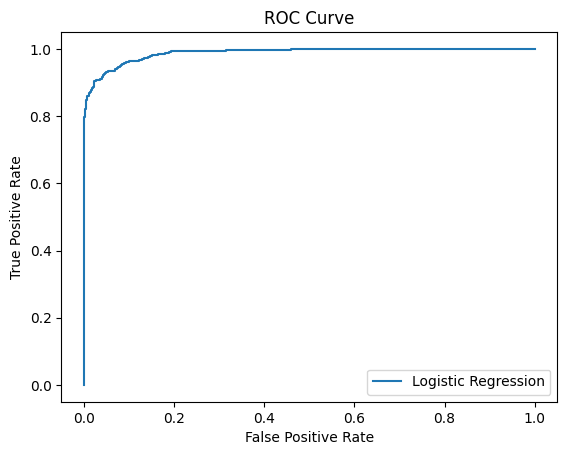

In [64]:
# Predictions
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:,1]

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

# ROC-AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [65]:
feature_importance = pd.DataFrame(log_reg.coef_[0], index=X_train.columns, columns=['Coefficient']).sort_values('Coefficient', ascending=False)

print(feature_importance)

                                   Coefficient
Monthly Charge                        1.245267
Referred a Friend                     0.873089
Offer_Offer A                         0.814623
Contract_Month-to-Month               0.723300
Offer_Offer E                         0.426536
Number of Dependents                  0.409399
Zip Code                              0.327933
Senior Citizen                        0.310174
Internet Type_Cable                   0.308715
City                                  0.214409
Streaming Music                       0.207277
ID                                    0.192378
Total Charges                         0.185956
Total Revenue                         0.181230
Multiple Lines                        0.128214
Total Long Distance Charges           0.115903
Payment Method_Mailed Check           0.100738
Payment Method_Bank Withdrawal        0.099921
Paperless Billing                     0.097256
Offer_Offer B                         0.077574
Avg Monthly G

## 2. Logistic Regression from scratch

Implementing Logistic Regression from scratch involves the following steps:

1. **Sigmoid Function**: We have to define the sigmoid function, which maps any real-valued number into the range of [0, 1]. This is useful for the probability estimate in logistic regression.

  - $\sigma(z) = \frac{1}{1 + e^{-z}}$, where $z = w^Tx + b$, with $w$ being the weight vector, $x$ the input feature vector, and $b$ the bias.

2. **Cost Function**: We have to implement the cost function known as binary cross-entropy or log loss. This measures the performance of a classification model where the prediction is a probability value between 0 and 1.

  - $L_{CE}(ŷ,y) = -\frac{1}{m} \sum_{i=1}^{m} [y \log(\hat{y}) + (1 - y) \log(1 - \hat{y})]$, where $m$ is the number of training examples, $y$ is the actual label, and $\hat{y}$ is the predicted probability.


3. **Gradient Descent**: We also have to develop the gradient descent algorithm to minimize the cost function. This involves calculating the gradient of the cost function and updating the model's parameters iteratively.
  - The parameters $w$ and $b$ are updated as
  
    $w \leftarrow w - \alpha \frac{\partial L_{CE}(ŷ,y)}{\partial w}$ and
  
    $b \leftarrow b - \alpha \frac{\partial L_{CE}(ŷ,y)}{\partial b}$, where $\alpha$ is the learning rate.

  - The gradients are calculated as follows:

    $\frac{\partial L_{CE}(ŷ,y)}{\partial w} = \frac{1}{m} (ŷ-y) x_i^T$

    $\frac{\partial L_{CE}(ŷ,y)}{\partial b} = \frac{1}{m} (ŷ-y)$

   
4. **Model Training**: Now, next step would be to use the gradient descent within a training function to fit the model to our data. We will also need to determine the number of iterations and the learning rate, which are usually the parameters given to us.

5. **Prediction Function**: Once the model training is complete, we should have a function to predict the labels for the dataset. This involves applying the sigmoid function to your data and then converting the probabilities to class labels based on a threshold.
  - Eg: if $\hat{y} = σ(z) \geq 0.5$, predict class 1; otherwise, predict class 0

6. **Evaluation**: Now finally, after making predictions, we evaluate your model using metrics like accuracy, precision, recall, and F1-score.

Resources:
https://developer.ibm.com/articles/implementing-logistic-regression-from-scratch-in-python/

In [66]:
class MyLogisticRegression:
    def __init__(self, learning_rate=0.1, iterations=100):
        self.epochs = iterations
        self.learning_rate = learning_rate
        self.weights = None
        self.bias = None


    def sigmoid(self, z):
        def sigmoid_function(x):
            if x >= 0:
                return 1 / (1 + np.exp(-x))
            else:
                return np.exp(x) / (1 + np.exp(x))

        # Apply the function to each element of z
        vectorized_sigmoid = np.vectorize(sigmoid_function)
        return vectorized_sigmoid(z)

    def loss_function(self, X, y):
        total_cost = 0

        # Get predictions
        z = np.dot(X, self.weights) + self.bias
        predictions = self.sigmoid(z)

        # Compute the loss
        total_cost = -np.mean(y * np.log(predictions + 1e-9) + (1 - y) * np.log(1 - predictions + 1e-9))

        return total_cost


    def fit(self, X, y):
        # Initialize parameters
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Learn the weights and bias using gradient descent
        for i in range(self.epochs):
            # Get predictions
            z = np.dot(X, self.weights) + self.bias
            predictions = self.sigmoid(z)

            # Calculate the gradients
            dw = np.array([np.mean(grad) for grad in np.dot(X.T, (predictions - y))])
            db = np.mean(predictions - y)

            # Update the weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db


    def predict_proba(self, X):
        model = np.dot(X, self.weights) + self.bias
        predictions = self.sigmoid(model)
        return predictions

    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)
        return [1 if i > threshold else 0 for i in probabilities]


In [67]:
my_log_model = MyLogisticRegression(iterations=1000)
my_log_model.fit(X_train, y_train)

Accuracy: 0.9418026969481902
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1009
           1       0.94      0.85      0.89       400

    accuracy                           0.94      1409
   macro avg       0.94      0.91      0.93      1409
weighted avg       0.94      0.94      0.94      1409

ROC-AUC Score: 0.9838999008919722


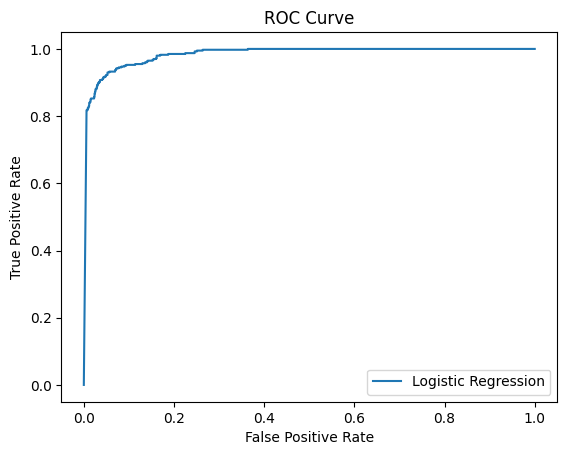

In [68]:
# Predictions
y_pred = my_log_model.predict(X_test)
y_pred_proba = my_log_model.predict_proba(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

# ROC-AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## 3. SVM using library

In [69]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

In [70]:
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

SVC(probability=True)

Accuracy: 0.950319375443577
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1009
           1       0.95      0.87      0.91       400

    accuracy                           0.95      1409
   macro avg       0.95      0.93      0.94      1409
weighted avg       0.95      0.95      0.95      1409

ROC-AUC Score: 0.983709117938553


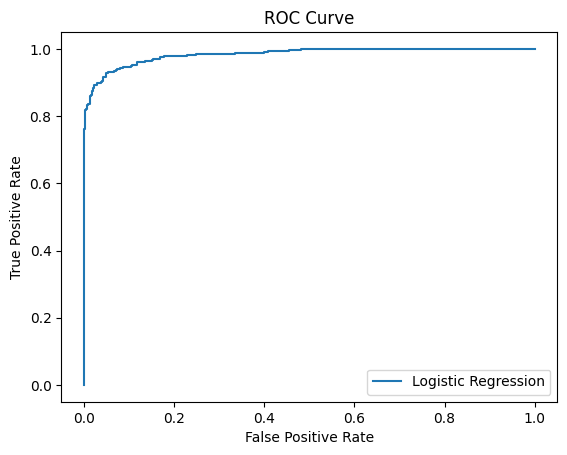

In [71]:
# Predictions
y_pred = svm_model.predict(X_test)
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

# ROC-AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [72]:
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, verbose=2, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Find the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'kernel': 'linear'}
Best Cross-Validation Score: 0.962548995194649


Accuracy: 0.9595457771469127
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1032
           1       0.94      0.90      0.92       377

    accuracy                           0.96      1409
   macro avg       0.95      0.94      0.95      1409
weighted avg       0.96      0.96      0.96      1409

ROC-AUC Score: 0.992347017457282


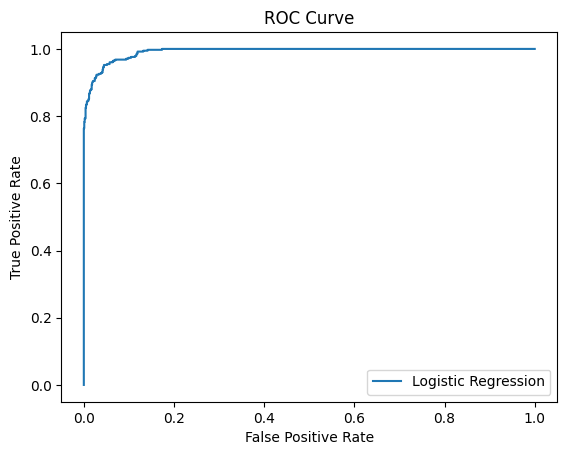

In [ ]:
best_svm_model = grid_search.best_estimator_

# Predictions
y_pred = best_svm_model.predict(X_test)
y_pred_proba = best_svm_model.predict_proba(X_test)[:, 1]

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

# ROC-AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## 4. SVM from scratch

Implementing SVM from scratch involves the following steps:

SVM finds the maximal margin hyperplane that separates the observations. The equation of a hyperplane is given by, $y(w.x - b)$

1. **Objective Function**: The objective function in SVM is composed of two parts: a margin term and a hinge loss term for misclassification.

  - Our goal is to minimize $\quad \frac{1}{2}\|w\|^2 + C \sum_{i=1}^{n} \max(0, 1 - y_i(w \cdot x_i - b))$ where $C$ is the regularization parameter.
  - Here, the first term encourages larger margins, and the second term is the cumulative hinge loss across all training samples, penalizes misclassifications.
  - For the sake of simplicity, we chose the primal formulation for SVMs. We could also explore the dual formulation using Lagrange Multipliers which is better suited for implementing the kernel trick.

2. **Gradient Descent**: We also have to develop the gradient descent algorithm to minimize the cost function. This involves calculating the gradient of the cost function and updating the model's parameters iteratively.
  - The parameters $w$ and $b$ are updated as
  
    $w \leftarrow w - \alpha \frac{\partial J}{\partial w}$ and
  
    $b \leftarrow b - \alpha \frac{\partial J}{\partial b}$, where $\alpha$ is the learning rate.

  - The gradients are calculated as follows:
  - if $y_i(w.x_i - b) \geq 1$

    $\frac{\partial J}{\partial w} = w$

    $\frac{\partial J}{\partial b} = 0$

  - if $y_i(w.x_i - b) < 1$

    $\frac{\partial J}{\partial w} = w - C y_i.x_i$

    $\frac{\partial J}{\partial b} = y_i$

3. **Model Training**: Now, next step would be to use the gradient descent within a training function to fit the model to our data. We will also need to determine the number of iterations and the learning rate, which are usually the parameters given to us.

4. **Prediction Function**: Once the model training is complete, we use the equation of the hyperplane to predict the labels for the dataset. All the points above the hyperplane will be classified as true cases, while the points below will be classified as false cases.

In [76]:
class SimpleSVM:
    def __init__(self, learning_rate=0.001, C=0.01, iterations=1000):
        self.lr = learning_rate
        self.C = C
        self.epochs = iterations
        self.w = None
        self.b = None

    def fit(self, X, y):
        # Convert X to a NumPy array with dtype float64
        X = np.array(X, dtype=np.float64)
        y = np.array(y)
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)

        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.epochs):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    dw = self.w
                    db = 0
                else:
                    dw = self.w - self.C * np.dot(x_i, y_[idx])
                    db = self.C * y_[idx]

                self.w -= self.lr * dw
                self.b -= self.lr * db

    def predict(self, X):
        # Convert X to NumPy array with dtype float64
        X = np.array(X, dtype=np.float64)
        y_pred = np.sign(self.predict_proba(X))
        return np.where(y_pred <= -1, 0, 1)

    def predict_proba(self, X):
        # Convert X to NumPy array with dtype float64
        X = np.array(X, dtype=np.float64)
        return np.dot(X, self.w) - self.b

In [77]:
my_svm_model = SimpleSVM(iterations=150, C=10)
my_svm_model.fit(X_train, y_train)

Accuracy: 0.9368346344925479
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1009
           1       0.92      0.85      0.88       400

    accuracy                           0.94      1409
   macro avg       0.93      0.91      0.92      1409
weighted avg       0.94      0.94      0.94      1409

ROC-AUC Score: 0.978637264618434


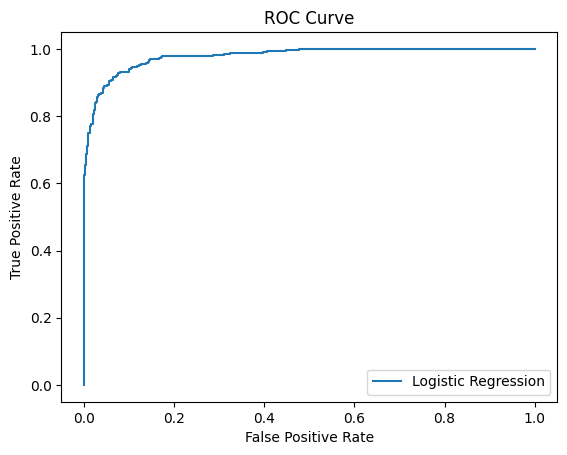

In [78]:
# Predictions
y_pred = my_svm_model.predict(X_test)
y_pred_proba = my_svm_model.predict_proba(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

# ROC-AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()